In [1]:
import sys
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
from src.utils.metadata_functions import load_metadata_as_dataframe
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import os
import json
import glob
import argparse
from pathlib import Path
from src.cmos_plotter import Waveform_plotter as wp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

2025-06-02 15:40:55,285 matplotlib data path: /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data
2025-06-02 15:40:55,290 CONFIGDIR=/home/kvulic/.config/matplotlib
2025-06-02 15:40:55,353 interactive is False
2025-06-02 15:40:55,353 platform is linux
2025-06-02 15:40:55,404 CACHEDIR=/home/kvulic/.cache/matplotlib


In [2]:
MAIN_PATH  = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Pickle_files_1851/'
RECORDINGS_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/2_Raw_Data/1851_recordings/'
#metadata = load_metadata_as_dataframe(file_path=RECORDINGS_PATH)
#MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/'
#OUTPUT_PATH = '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/Results/'

In [4]:
with open(os.path.join(MAIN_PATH, 'Results/combined_unit_metrics.pkl'), 'rb') as f:
    data = pd.read_pickle(f)
  

In [24]:
a = list(data.filename.unique())
len(a)

569

In [35]:
filename = 'ID1765_N9_DIV49_DATE20241108_1016_spontaneous_NGN2.raw.h5'
filepath = os.path.join(MAIN_PATH, f'Sorters/Sorter_{filename}/wf_folder_curated/waveform_metrics_output')
with open(os.path.join(filepath, 'waveforms.pkl'), 'rb') as f:
    wf = pd.read_pickle(f)
wf_df = pd.DataFrame(wf)
wf_df['waveforms_best_channel'][0].shape

(79, 80)

In [39]:
def load_and_merge_waveforms(filepath,filename):
    """
    Load and merge waveform data from a pickle file
    
    Parameters:
    filepath (str): Full path to the pickle file
    
    Returns:
    pandas.DataFrame: Merged waveform data
    """
    # Extract metadata from filename
    metadata = wp.extract_metadata_from_filename(filename)
    print(metadata)
    # Load pickle file
    with open(os.path.join(filepath,'waveforms.pkl'), 'rb') as f:
        waveform_dict = pickle.load(f)
    
    # Check if the dictionary is empty
    if not waveform_dict:
        print(f"Skipping empty pickle file: {filename}")
        return None
    waveform_dict = pd.DataFrame(waveform_dict)
    # Process each unit in the pickle file
    all_waveforms = []
    for i in range(len(waveform_dict)):
        unit_id = waveform_dict['unit_ids'][i]
        for j in range(len(waveform_dict['waveforms_best_channel'][i])):
            waveform = waveform_dict['waveforms_best_channel'][i][j]
            waveform = np.array(waveform)
            # Create a DataFrame for the current unit
            df = pd.DataFrame({
                'unit_id': [unit_id],
                'waveform': [waveform],
                'chip_id': [metadata['chip_id']],
                'div': [metadata['div']],
                'cell_type': [metadata['cell_type']],
                'area': [metadata['network_id']]
            })
            all_waveforms.append(df)
    
    return pd.concat(all_waveforms, ignore_index=True)

df = load_and_merge_waveforms(filepath,filename)

1765 49 NGN2 9
{'chip_id': 1765, 'div': 49, 'cell_type': 'NGN2', 'network_id': 9}


In [41]:
df['waveform'][0].shape

(80,)

Waveforms

In [4]:
all_dfs = pd.DataFrame()
b=0
for filename in data.filename.unique():
    try:
    #if filename == 'ID1103_N10_DIV17_DATE20240419_0915_spontaneous_CTRL.raw.h5':
        filepath = os.path.join(MAIN_PATH, f'Sorters/Sorter_{filename}/wf_folder_curated/waveform_metrics_output')
        
        #print(filename)
        # Load and process waveform metrics
        df = wp.load_and_merge_waveforms(filepath, filename)
        if df is not None:
            #parent_folder = os.path.dirname(filepath)  # Get the parent folder of filepath
            #with open(os.path.join(parent_folder, 'sparsity.json'), 'rb') as f:
            #    unit_ids = json.load(f)
            #unit_ids = list(map(int, unit_ids['unit_id_to_channel_ids'].keys()))
            #print(unit_ids)
            #df['unit_index'] = df['unit_id'].map(lambda x: unit_ids.index(x) if x in unit_ids else None)
            #print(df['unit_index'], df['unit_id'])
            #all_dfs.append(df)
            all_dfs = pd.concat([all_dfs, df], axis=0, ignore_index=True)
        
    except Exception as e:
        b+=1
        print(f'Error with {filename}: {e}')
        continue
print(b)

1765 140 NGN2 8
{'chip_id': 1765, 'div': 140, 'cell_type': 'NGN2', 'network_id': 8}
1811 63 CoCulture 3
{'chip_id': 1811, 'div': 63, 'cell_type': 'CoCulture', 'network_id': 3}
2034 35 GABA 3
{'chip_id': 2034, 'div': 35, 'cell_type': 'GABA', 'network_id': 3}
1811 33 CoCulture 0
{'chip_id': 1811, 'div': 33, 'cell_type': 'CoCulture', 'network_id': 0}
1908 23 NGN2 4
{'chip_id': 1908, 'div': 23, 'cell_type': 'NGN2', 'network_id': 4}
2034 23 GABA 1
{'chip_id': 2034, 'div': 23, 'cell_type': 'GABA', 'network_id': 1}
1821 28 NGN2 1
{'chip_id': 1821, 'div': 28, 'cell_type': 'NGN2', 'network_id': 1}
1811 70 CoCulture 5
{'chip_id': 1811, 'div': 70, 'cell_type': 'CoCulture', 'network_id': 5}
1908 56 NGN2 8
{'chip_id': 1908, 'div': 56, 'cell_type': 'NGN2', 'network_id': 8}
1135 12 CoCulture 3
{'chip_id': 1135, 'div': 12, 'cell_type': 'CoCulture', 'network_id': 3}
1908 35 NGN2 0
{'chip_id': 1908, 'div': 35, 'cell_type': 'NGN2', 'network_id': 0}
1765 49 NGN2 4
{'chip_id': 1765, 'div': 49, 'cell_type':

Waveform metrics merging

In [5]:
pickle.dump(all_dfs, open(os.path.join(MAIN_PATH, 'Results/waveforms_all.pkl'), 'wb'))

1. Recording

In [35]:
all_dfs = pd.DataFrame()
b=0
for filename in data.filename.unique():
    try:
    #if filename == 'ID1103_N10_DIV17_DATE20240419_0915_spontaneous_CTRL.raw.h5':
        filepath = os.path.join(MAIN_PATH, f'Sorters/Sorter_{filename}/wf_folder_curated/waveform_metrics_output')
        #print(filename)
        # Load and process waveform metrics
        df = wp.load_and_process_waveform_metrics(filepath, filename)
        if df is not None:
            parent_folder = os.path.dirname(filepath)  # Get the parent folder of filepath
            with open(os.path.join(parent_folder, 'sparsity.json'), 'rb') as f:
                unit_ids = json.load(f)
            unit_ids = list(map(int, unit_ids['unit_id_to_channel_ids'].keys()))
            #print(unit_ids)
            df['unit_index'] = df['unit_id'].map(lambda x: unit_ids.index(x) if x in unit_ids else None)
            #print(df['unit_index'], df['unit_id'])
            #all_dfs.append(df)
            all_dfs = pd.concat([all_dfs, df], axis=0, ignore_index=True)
        
    except Exception as e:
        b+=1
        print(f'Error with {filename}: {e}')
        continue
print(b)

1765 140 NGN2 8
1811 63 CoCulture 3
2034 35 GABA 3
1811 33 CoCulture 0
1908 23 NGN2 4
2034 23 GABA 1
1821 28 NGN2 1
1811 70 CoCulture 5
1908 56 NGN2 8
1135 12 CoCulture 3
1908 35 NGN2 0
1765 49 NGN2 4
1821 12 NGN2 0
2070 19 CoCulture 7
1135 28 CoCulture 3
2070 28 CoCult 0
2034 35 GABA 7
2074 35 GABA 4
1135 23 CoCulture 7
2074 35 GABA 2
1765 49 NGN2 3
2074 19 GABA 5
1135 26 CoCulture 4
1811 28 CoCulture 3
1811 45 CoCultureNoglia 4
1765 140 NGN2 4
1908 56 NGN2 3
1908 35 NGN2 7
2074 28 GABA 1
1765 56 NGN2 6
2034 35 GABA 1
2034 16 GABA 6
1908 8 Spontaneous 5
2070 56 CoCulture 1
1908 19 NGN2 7
1135 19 CoCulture 6
1811 10 CoCulture 1
1765 27 NGN2 9
1708 22 NGN2 0
2034 28 GABA 4
1765 49 NGN2 2
2074 21 GABA 7
1765 101 NGN2 8
1135 28 CoCulture 2
1908 28 NGN2 8
1811 28 CoCulture 2
1811 17 CoCulture 0
1821 17 NGN2 1
1765 140 NGN2 0
1135 26 CoCulture 0
2074 19 GABA 6
2074 21 GABA 1
1765 89 NGN2 4
1135 21 CoCulture 3
1908 28 NGN2 4
2034 28 GABA 0
1135 26 CoCulture 7
1765 63 NGN2 2
1765 101 NGN2 1
1

In [38]:
all_dfs.keys()

Index(['unit_id', 'chip_id', 'div', 'cell_type', 'network_id',
       'peak_to_trough_duration', 'peak_trough_ratio', 'repolarization_slope',
       'recovery_slope', 'half_width', 'peak_idx', 'trough_idx',
       'amplitude uV', 'template', 'unit_index'],
      dtype='object')

In [37]:
import pickle
pickle.dump(all_dfs, open(os.path.join(MAIN_PATH, 'Results/waveform_metrics_all_recordings.pkl'), 'wb'))

In [6]:
#combined_df_all_rec.to_csv('/itet-stor/kvulic/neuronies/TANGO2/Processed_Data/Waveforms/waveform_metrics_all_recordings.csv')
all_waveforms = pd.read_pickle(os.path.join(MAIN_PATH, 'Results/waveform_metrics_all_recordings.pkl'))
all_waveforms

,unit_id,chip_id,div,cell_type,network_id,peak_to_trough_duration,peak_trough_ratio,repolarization_slope,recovery_slope,half_width,peak_idx,trough_idx,amplitude uV,template,unit_index
0,0,1851,107,inhibiton,4,0.55,0.297587,-6.662749e+05,-122546.081543,0.25,51,40,358.667145,"[0.3242766, 1.5444318, 1.955225, 1.6052731, 1....",0
1,1,1851,107,inhibiton,4,0.30,0.160012,-5.307816e+05,-39850.402832,0.20,46,40,288.912354,"[0.560887, 1.9637749, 2.4257457, 3.241936, 4.2...",1
2,2,1851,107,inhibiton,4,0.75,0.295331,-5.105753e+05,-113770.271301,0.25,55,40,278.614624,"[-2.9403548, -1.4579191, 1.2191381, 3.043124, ...",2
3,3,1851,107,inhibiton,4,0.50,0.290749,-6.755627e+05,-125853.683472,0.35,53,43,343.152924,"[-5.4251046, -4.651471, -3.885988, -2.413133, ...",3
4,4,1851,107,inhibiton,4,0.50,0.282480,-6.859425e+05,-128174.133301,0.35,49,39,347.557953,"[-1.436834, 1.8878139, 4.0438485, 4.628662, 5....",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,72,1851,107,inhibiton,1,0.55,0.152108,-1.214026e+06,-65107.696533,0.25,51,40,826.420410,"[1.6416147, 1.801101, 2.0644445, 2.4892185, 2....",68
1428,73,1851,107,inhibiton,1,0.95,0.058488,-1.875814e+05,-4842.138767,0.20,59,40,180.188080,"[-1.3898323, -2.9015675, -4.141179, -3.6248708...",69
1429,74,1851,107,inhibiton,1,1.45,0.048301,-2.638425e+05,-3557.270527,0.30,69,40,201.826630,"[-2.1910121, -2.4642687, -1.9150556, -1.703838...",70
1430,75,1851,107,inhibiton,1,1.95,0.040483,-2.754563e+05,0.000000,0.00,79,40,686.837769,"[-10.838416, -12.871038, -14.745583, -15.3211,...",71


In [ ]:
import numpy as np
import pandas as pd

# Function to convert string to numpy array
def string_to_numpy_array(s):
    # Remove brackets
    s = s.strip('[]')
    # Split by whitespace and convert to floats
    values = [float(x) for x in s.split() if x.strip()]
    # Create numpy array with float32 dtype
    return np.array(values, dtype=np.float32)
# Apply the function to your dataframe column
all_waveforms['template'] = all_waveforms['template'].apply(string_to_numpy_array)

# Verify the conversion worked for the first row
print(type(all_waveforms['template'].iloc[0]))  # Should be numpy.ndarray
print(all_waveforms['template'].iloc[0].dtype)  # Should be float32

AttributeError: 'numpy.ndarray' object has no attribute 'strip'

In [9]:
metrics_to_plot = [
    'amplitude uV', 
    'peak_to_trough_duration', 
    'peak_trough_ratio', 
    'repolarization_slope', 
    'recovery_slope',
    'half_width'
]


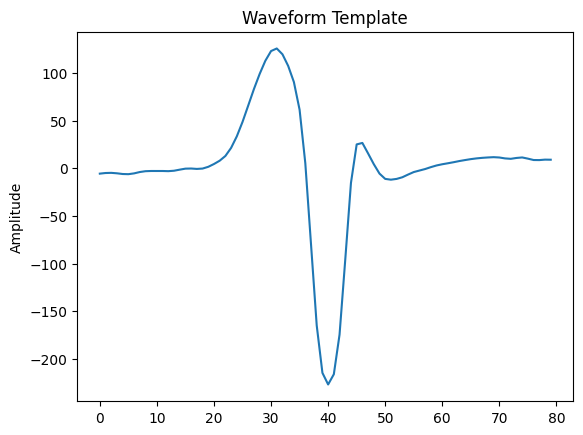

In [7]:
plt.plot(np.array(all_waveforms.iloc[10]['template']))
plt.title("Waveform Template")
plt.ylabel("Amplitude")
plt.show()

2025-06-02 15:42:22,565 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-06-02 15:42:22,770 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-06-02 15:42:22,770 Writing TrueType font.


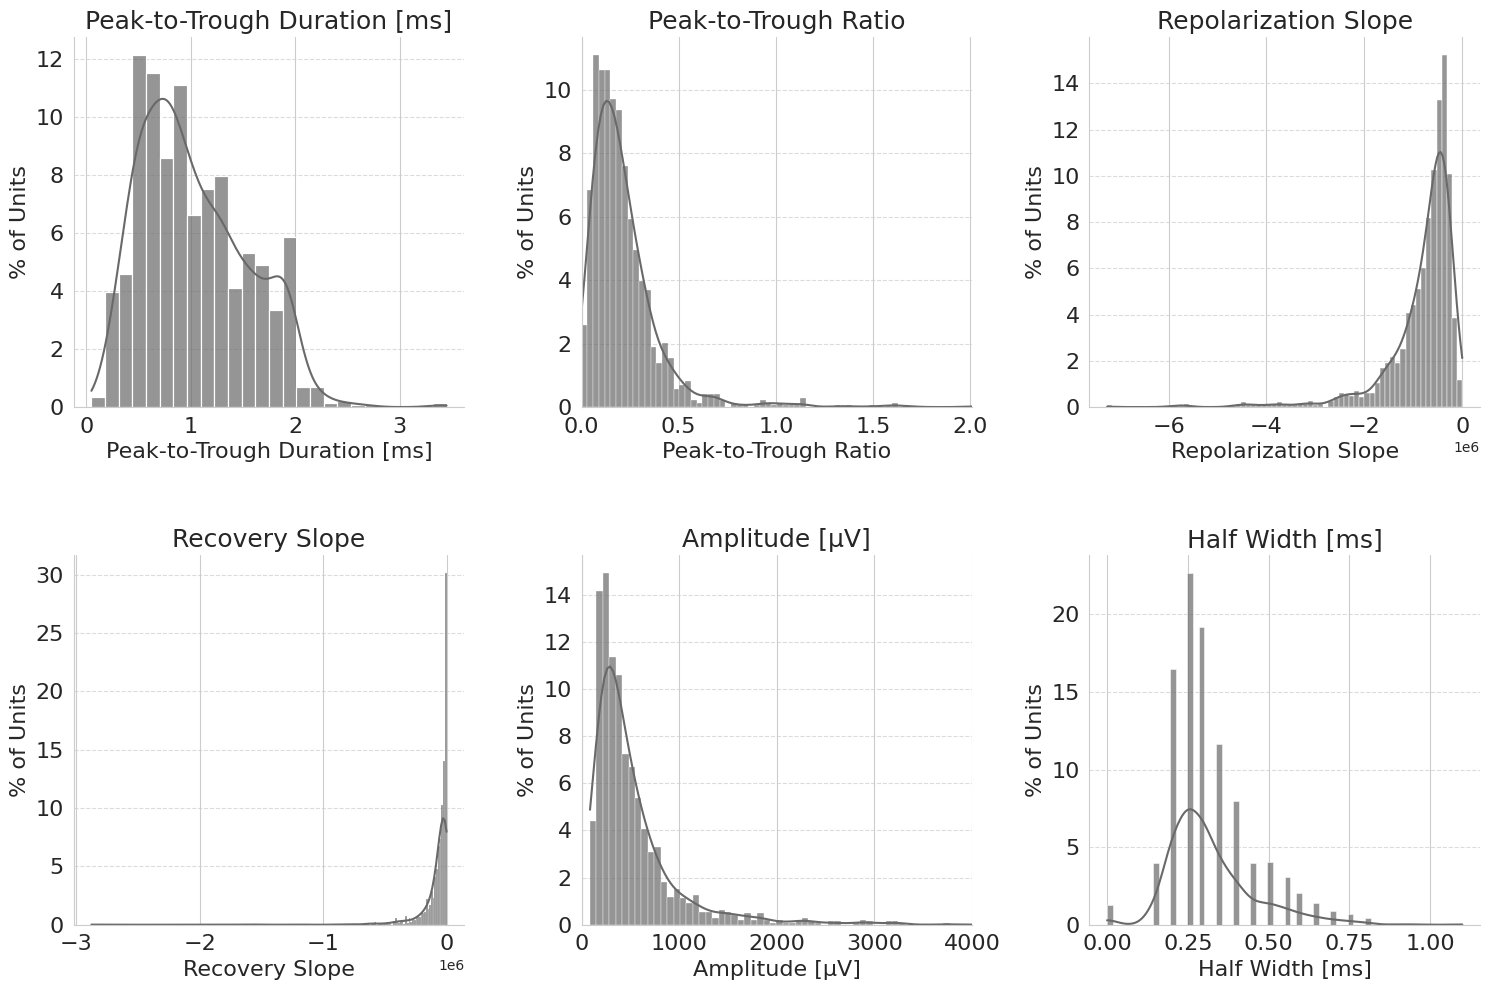

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# List of columns to plot based on your screenshot
columns_to_plot = [
    'peak_to_trough_duration', 
    'peak_trough_ratio', 
    'repolarization_slope', 
    'recovery_slope', 
    'amplitude uV',
    'half_width'
]

# Define custom titles and labels with proper units
custom_titles = {
    'peak_to_trough_duration': 'Peak-to-Trough Duration [ms]',
    'peak_trough_ratio': 'Peak-to-Trough Ratio',
    'repolarization_slope': 'Repolarization Slope',
    'recovery_slope': 'Recovery Slope',
    'amplitude uV': 'Amplitude [μV]',  # Corrected with proper micro symbol
    'half_width': 'Half Width [ms]'
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes

# Set the style
plt.style.use('default')
sns.set_style('whitegrid')

# Color for all distributions
color = 'dimgray'

# Create histograms for each column
for i, column in enumerate(columns_to_plot):
    if i < len(axes):
        # Create histogram with KDE
        sns.histplot(
            data=all_waveforms,
            x=column,
            kde=True,
            color=color,
            alpha=0.7,
            ax=axes[i],
            stat='percent'  # Use percentage instead of count
        )

        if column == 'amplitude uV':
            # Set x-axis limits for amplitude
            axes[i].set_xlim(0, 4000)
        if column == 'peak_trough_ratio':
            # Set x-axis limits for peak-to-trough ratio
            axes[i].set_xlim(0, 2.01)
        # Use custom titles with units
        axes[i].set_title(custom_titles[column], fontsize=18)
        axes[i].set_xlabel(custom_titles[column], fontsize=16)
        axes[i].set_ylabel('% of Units', fontsize=16)

        axes[i].tick_params(axis='both', labelsize=16)
        
        # Remove top and right spines
        sns.despine(ax=axes[i])
        
        # Add grid lines only for y-axis
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# If there are unused subplots, hide them
for j in range(len(columns_to_plot), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Save the figure if needed
plt.savefig(os.path.join(MAIN_PATH,'Results/waveform_distributions_new.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(MAIN_PATH,'Results/waveform_distributions_new.pdf'), dpi=300, bbox_inches='tight')
plt.show()

Total count for peak_to_trough_duration: 1432
Total count for peak_trough_ratio: 1432
Total count for repolarization_slope: 1432
Total count for recovery_slope: 1432
Total count for amplitude uV: 1432
Total count for half_width: 1432


2025-06-02 15:42:32,934 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-06-02 15:42:33,039 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-06-02 15:42:33,039 Writing TrueType font.


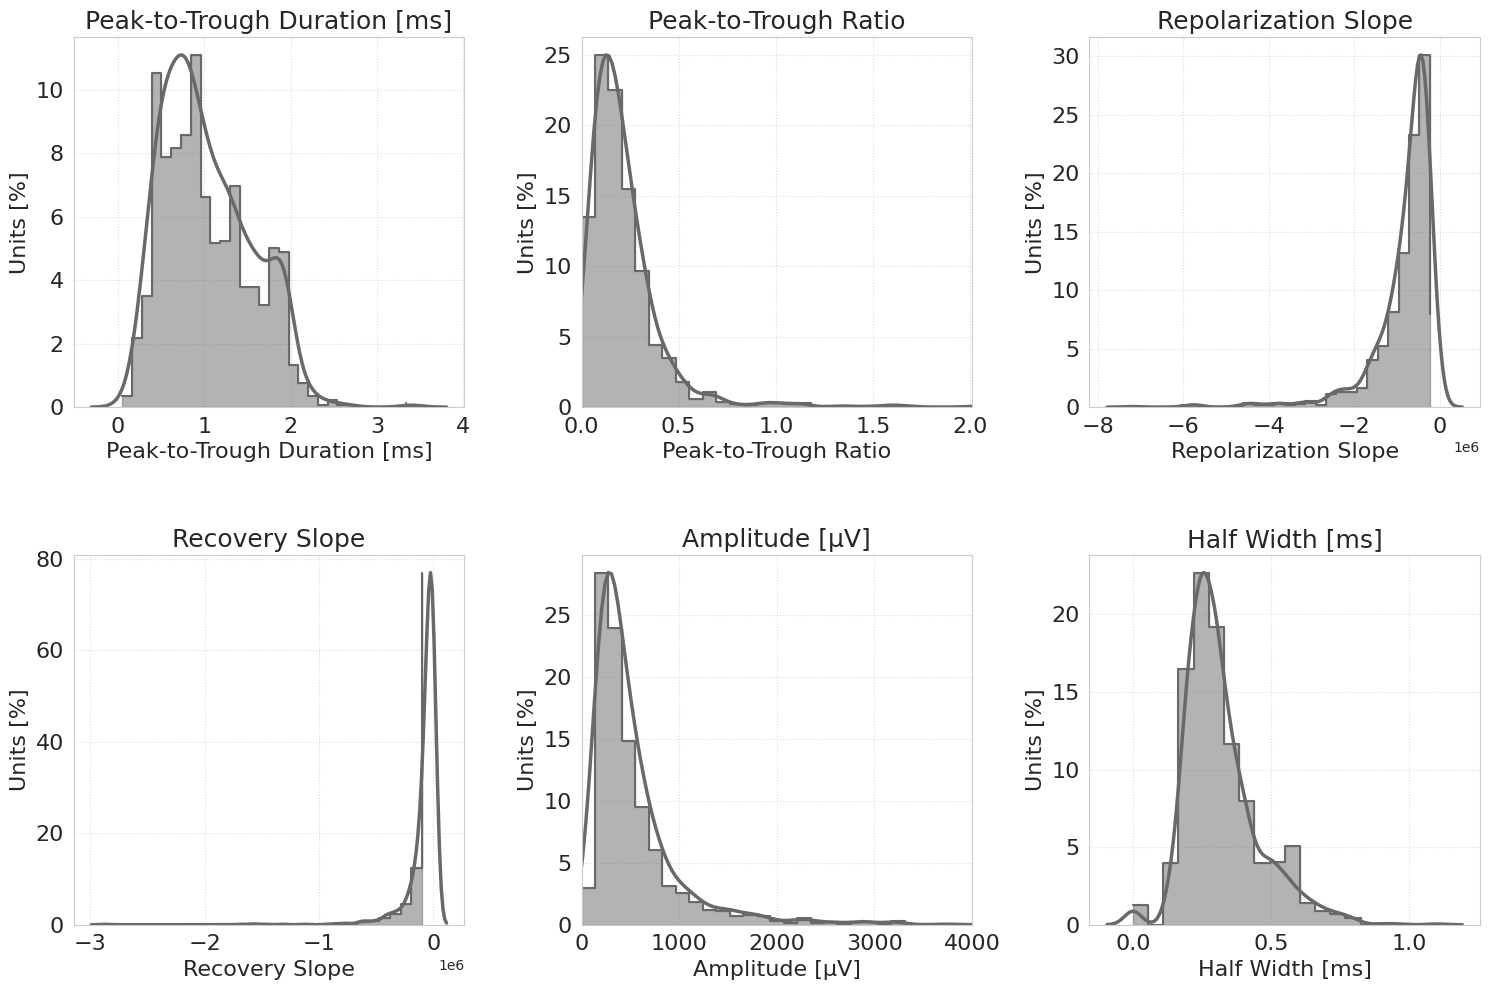

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# List of columns to plot based on your screenshot
columns_to_plot = [
    'peak_to_trough_duration', 
    'peak_trough_ratio', 
    'repolarization_slope', 
    'recovery_slope', 
    'amplitude uV',
    'half_width'
]

# Define custom titles and labels with proper units
custom_titles = {
    'peak_to_trough_duration': 'Peak-to-Trough Duration [ms]',
    'peak_trough_ratio': 'Peak-to-Trough Ratio',
    'repolarization_slope': 'Repolarization Slope',
    'recovery_slope': 'Recovery Slope',
    'amplitude uV': 'Amplitude [μV]',  # Corrected with proper micro symbol
    'half_width': 'Half Width [ms]'
}


# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes

# Set the style
plt.style.use('default')
sns.set_style('whitegrid')

# Color for all distributions
color = 'dimgray'

# Create histograms for each column
for i, column in enumerate(columns_to_plot):
    if i < len(axes):
        # Create histogram with step-like edges and fill
        # First, calculate the histogram data
        hist_data = all_waveforms[column].dropna()
        total_count = len(hist_data)  # Total number of rows for percentage calculation
        print (f"Total count for {column}: {total_count}")
        
        # Determine appropriate number of bins based on data
        if column == 'amplitude uV':
            bins = np.linspace(0, 4000, 30)
        elif column == 'peak_trough_ratio':
            bins = np.linspace(0, 2.01, 30)
        elif column == 'half_width':
            bins = 20
        else:
            bins = 30  # Default number of bins
            
        # Calculate histogram values
        hist, bin_edges = np.histogram(hist_data, bins=bins)
        # Convert to percentage of total rows
        hist = (hist / total_count) * 100
        
        # Plot the histogram as a step-filled area
        axes[i].fill_between(
            bin_edges[:-1], 
            hist, 
            step="post", 
            alpha=0.5, 
            color=color
        )
        
        # Add the step outline
        axes[i].step(
            bin_edges[:-1], 
            hist, 
            where='post', 
            color=color, 
            linewidth=1.5
        )
        
        # Add a KDE curve
        kde = sns.kdeplot(
            data=hist_data, 
            ax=axes[i],
            color=color,
            linewidth=2.5,
            common_norm=False,
            bw_adjust=1,  # Adjust bandwidth for smoother curve
        )
        
        # Scale KDE to match histogram percentage
        for line in axes[i].get_lines():
            ydata = line.get_ydata()
            # Scale to percentage of rows
            max_hist_val = hist.max() if len(hist) > 0 else 1
            line.set_ydata(ydata * 100 / ydata.max() * max_hist_val / 100)
        
        if column == 'amplitude uV':
            # Set x-axis limits for amplitude
            axes[i].set_xlim(0, 4000)
        if column == 'peak_trough_ratio':
            # Set x-axis limits for peak-to-trough ratio
            axes[i].set_xlim(0, 2.01)
            
        # Use custom titles with units
        axes[i].set_title(custom_titles[column], fontsize=18)
        axes[i].set_xlabel(custom_titles[column], fontsize=16)
        axes[i].set_ylabel('Units [%]', fontsize=16)

        axes[i].tick_params(axis='both', labelsize=16)
        
        # Remove top and right spines
        #sns.despine(ax=axes[i])
        
        # Add grid lines only for y-axis
        #axes[i].grid(axis='y', linestyle='-', alpha=0.7)
        axes[i].grid(True, linestyle=':', alpha=0.7) 

# If there are unused subplots, hide them
for j in range(len(columns_to_plot), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Save the figure if needed
plt.savefig(os.path.join(MAIN_PATH,'Results/waveform_distributions_new.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(MAIN_PATH,'Results/waveform_distribution_new.pdf'), dpi=300, bbox_inches='tight')
plt.show()

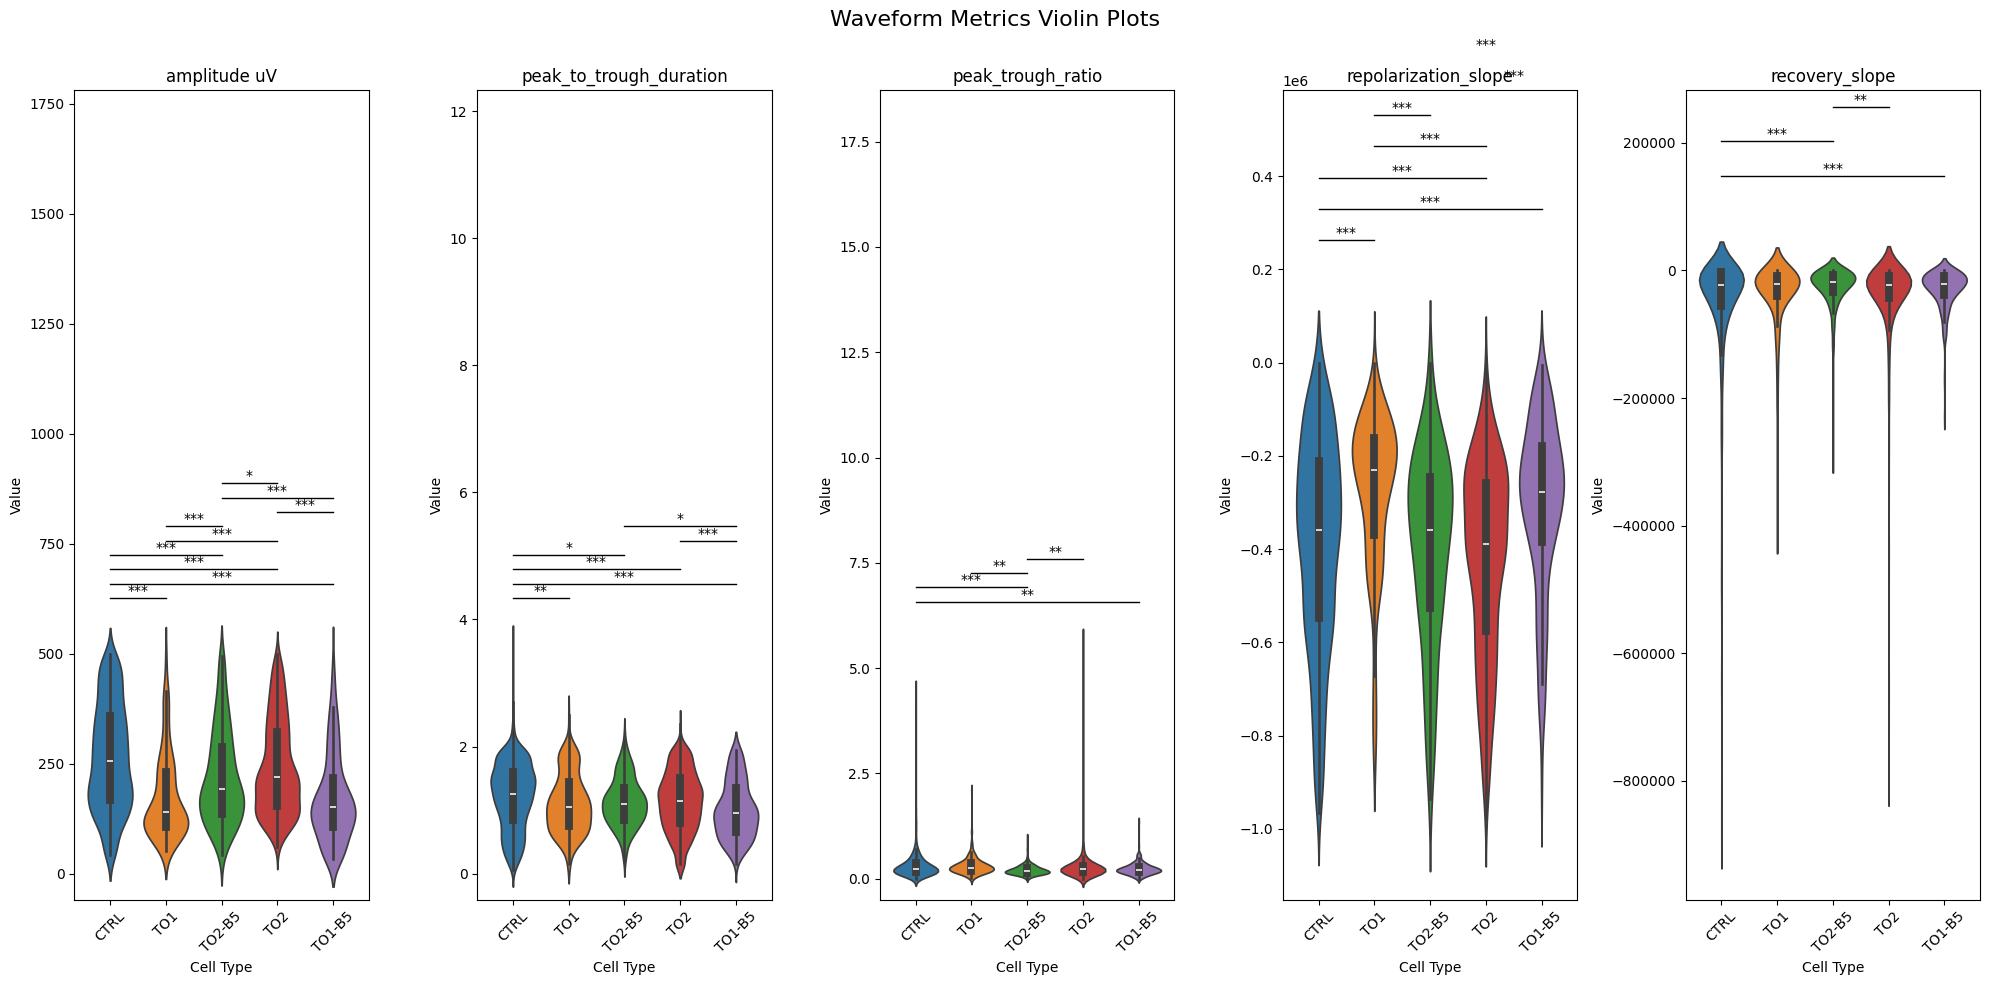

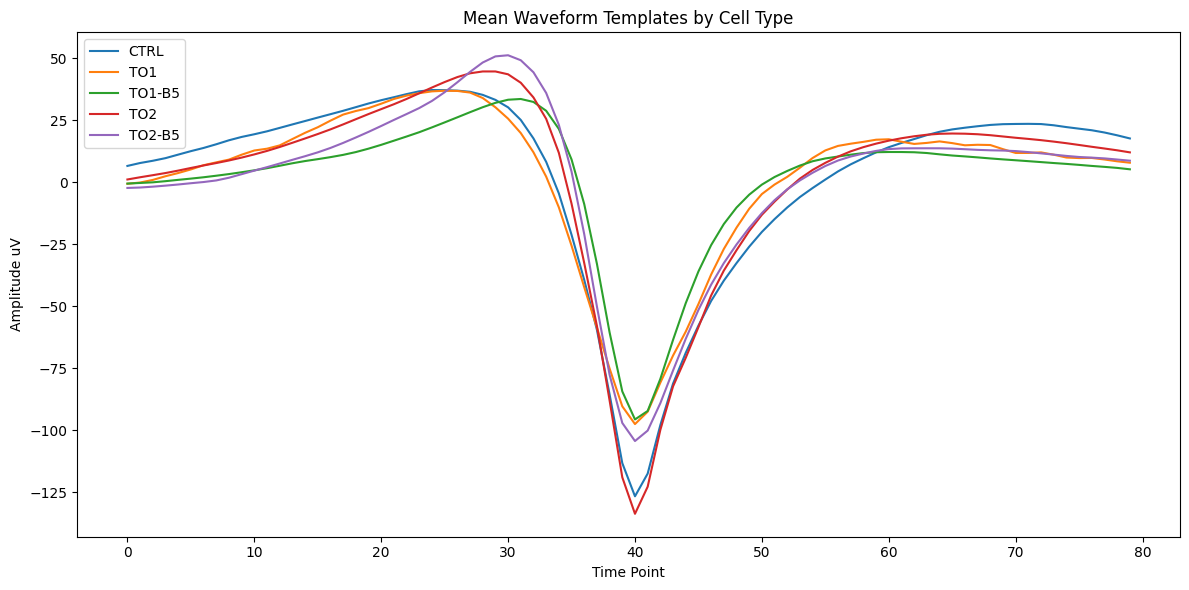

In [ ]:
#wfs_pickle = wfs_pickle[wfs_pickle['amplitude uV'] < 500].reset_index(drop=True)
wp.plot_metrics_violin_plots_w_test(wfs_pickle, metrics_to_plot)

# Plot mean templates
wp.plot_mean_templates(wfs_pickle)

In [39]:
#save all_waveforms as pickle
all_waveforms.to_pickle('/itet-stor/kvulic/neuronies/TANGO2/Processed_Data/Waveforms/waveform_metrics_all_recordings.pkl')

In [3]:
wfs_pickle = pd.read_pickle('/itet-stor/kvulic/neuronies/TANGO2/Processed_Data/Waveforms/waveform_metrics_all_recordings.pkl')
wfs_pickle

,Unnamed: 0,unit_id,chip_id,div,cell_type,network_id,peak_to_trough_duration,peak_trough_ratio,repolarization_slope,recovery_slope,peak_idx,trough_idx,amplitude uV,template,unit_index
0,0,7,1103,13,CTRL,11,1.35,0.489179,-543041.198730,-93439.483643,66,39,490.614930,"[78.9945, 87.38681, 96.351295, 103.83295, 108....",0
1,8,23,1103,13,CTRL,11,1.15,0.529383,-269975.372314,-129230.758667,63,40,221.347100,"[29.305162, 31.27347, 34.53726, 37.350956, 39....",8
2,11,3,1796,17,TO1,2,1.85,0.241468,-179737.365723,0.000000,77,40,106.845380,"[-12.428918, -9.702583, -8.340286, -7.963988, ...",0
3,12,4,1796,17,TO1,2,1.75,0.154417,-168915.618896,0.000000,75,40,112.462890,"[-12.799431, -10.84175, -9.195711, -8.423252, ...",1
4,21,11,1103,38,CTRL,10,1.80,0.280627,-322284.881592,0.000000,76,40,163.200840,"[3.2968636, 5.4520383, 7.7331796, 9.150459, 10...",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,5791,3,1796,18,TO1-B5,3,0.60,0.338559,-595845.703125,-21825.393677,52,40,299.674500,"[-9.825214, -28.397532, -47.248066, -59.883877...",3
3300,5793,6,1796,18,TO1-B5,3,0.55,0.318233,-277568.786621,-45008.884430,51,40,192.026640,"[-1.2744695, 0.32379836, 2.1361141, 2.610927, ...",5
3301,5794,7,1796,18,TO1-B5,3,0.75,0.560430,-205191.528320,-85240.959167,55,40,108.917816,"[-3.2293873, -2.7430377, -2.4705396, -2.312922...",6
3302,5795,9,1796,18,TO1-B5,3,0.90,0.289025,-184567.443848,-22112.655640,59,41,96.887560,"[-0.49445775, -0.71625596, -0.43099436, 1.3424...",7


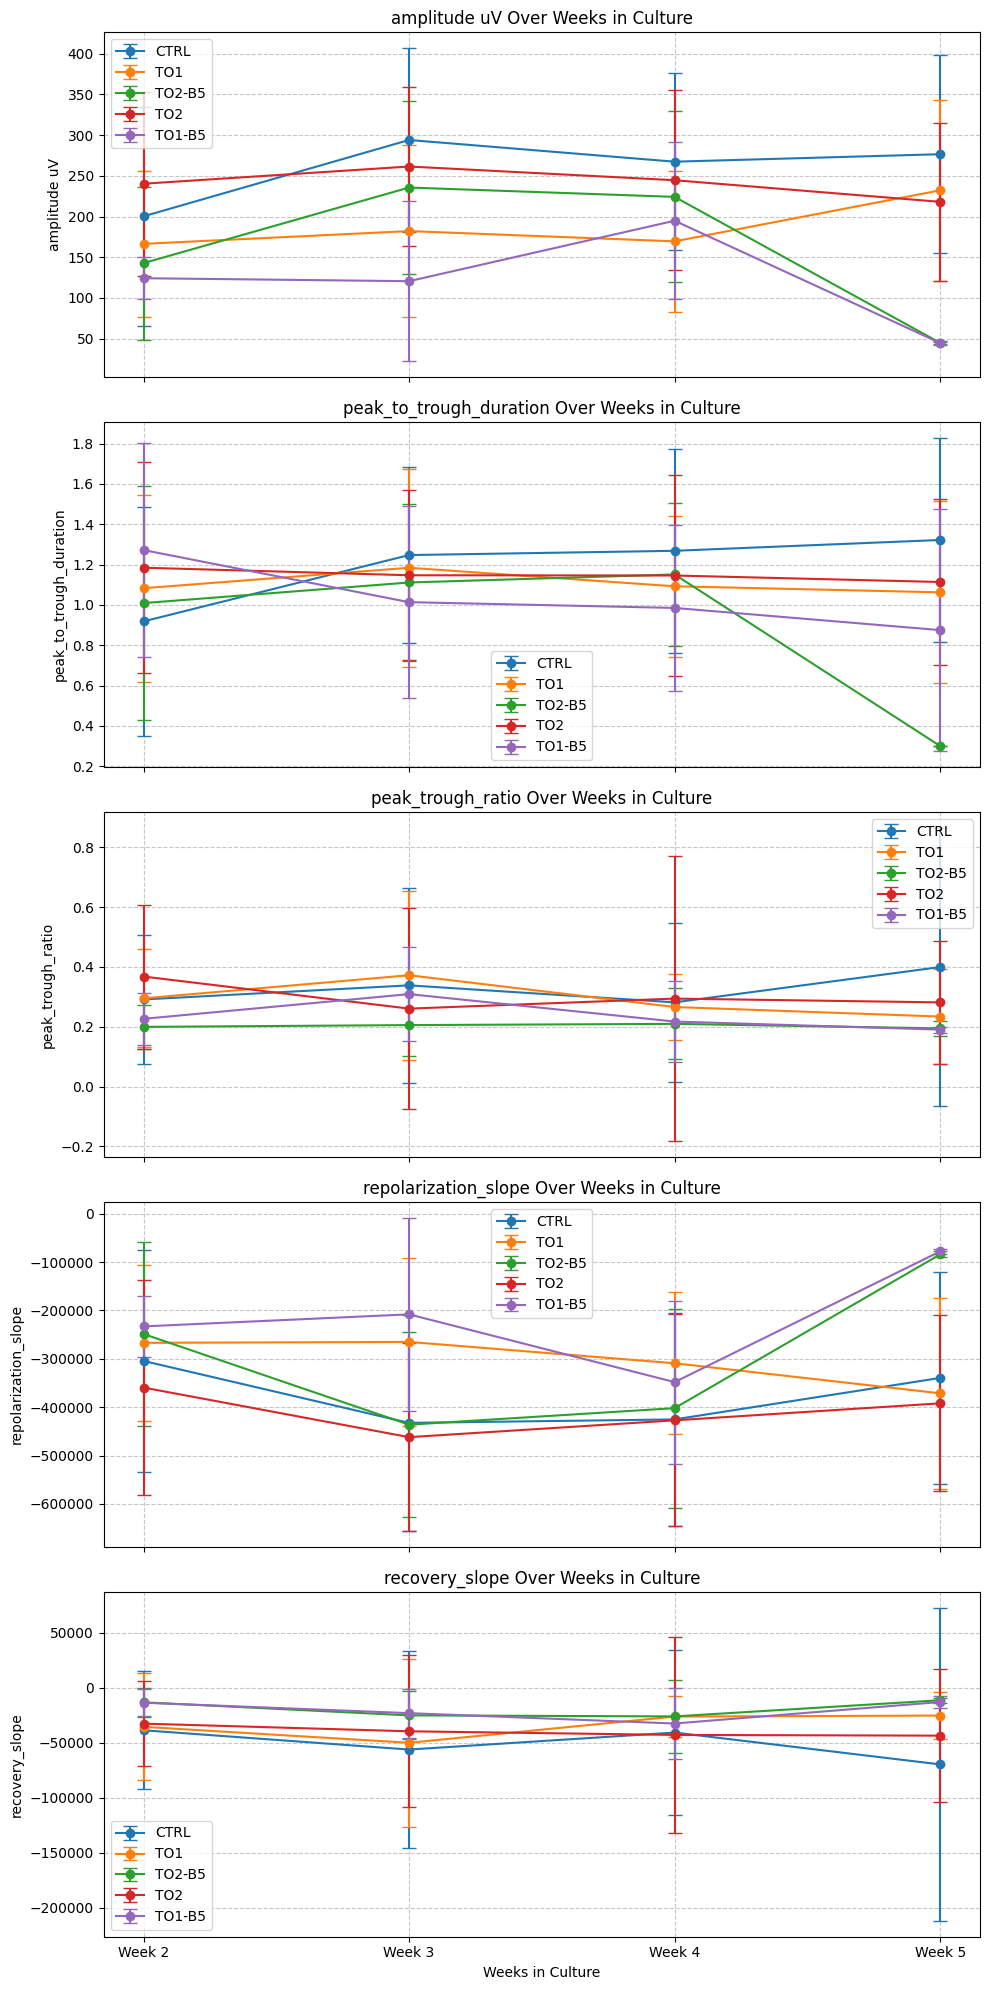

In [5]:
metrics_to_plot = [
    'amplitude uV', 
    'peak_to_trough_duration', 
    'peak_trough_ratio', 
    'repolarization_slope', 
    'recovery_slope'
]
wfs_pickle = wfs_pickle[wfs_pickle['amplitude uV'] < 500].reset_index(drop=True)
fig = wp.plot_metrics_over_weeks(wfs_pickle, metrics_to_plot)
plt.show()
